Here we will discuss the use of Generalized Linear Models in (a priori) motor ratemaking. The goal is to propose a premium that an insurance company should charge a client, for a yearly contract, based on a series of characteristics (of the driver, such as the age or the region, or of the car, such as the power, the make, or the type of gas). Those models are described in Kass et al. (2008), Frees (2009), de Jong & Zeller (2008), and Ohlsson & Johansson (2010).

### 1. Claims Frequency

#### 1.1. Dataset

In [1]:
library(CASdatasets)

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading required package: sp


The first dataset, freMTPLfreq, contains contract and client information from a French insurance company, related to some motor insurance portfolio.

    Att. 1 (numeric) PolicyID, contract number (used to link with the claims dataset)
    Att. 2 (numeric) ClaimNb, number of claims during the exposure period
    Att. 3 (numeric) Exposure, exposure, in years
    Att. 4 (factor) Power, power of the car (ordered categorical)
    Att. 5 (numeric) CarAge, age of car in years
    Att. 6 (numeric) DriverAge, age of driver in years (in France, people can drive a car at 18)
    Att. 7 (factor) Brand, brand of the car.
    Att. 8 (factor) Gas, with diesel or regular,
    Att. 9 (factor) Region, with dierent regions, in France (based on a standard French classification)
    Att. 10 (numeric) Density, density of inhabitants (number of inhabitants per square kilometer) in the city the driver of the car lives in

In [2]:
data(freMTPLfreq)
head(freMTPLfreq)

PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60
6,0,0.75,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


Remark:
In the French insurance market, there is a compulsory no-claim bonus system (see Lemaire (1984) for a description of the system). Insurance pricing in France is then a mix between a priori ratemaking, discussed in this chapter, and a posteriori ratemaking, which will be discussed in the next chapter. But one should keep in mind that because of this no-claim bonus system, or malus in the case where the insured claims a loss, there might be (financial) incentives not to declare some claims, if the associated loss is smaller than the malus the insured will have in the future.

It might be more convenient to work with categorized variables,
    
    Att. 5 (factor) agecar, [0,1), [1,4), [4,15), and [15,Inf)
    Att. 6 (factor) agedriver, (17,22], (22,26], (26,42], (42,74], and (74,Inf]
    Att. 10 (factor) density, [0-40), [40,200), [200,500), [500,4500), and [4500,Inf)

In [3]:
freMTPLfreq.f <- freMTPLfreq
freMTPLfreq.f$DriverAge <- cut(freMTPLfreq$DriverAge,c(17,22,26,42,74,Inf))
freMTPLfreq.f$CarAge <- cut(freMTPLfreq$CarAge,c(0,1,4,15,Inf),include.lowest = TRUE)
freMTPLfreq.f$Density <- cut(freMTPLfreq$Density,c(0,40,200,500,4500,Inf),include.lowest = TRUE)

#### 1.2. Annualized Claims Frequency

This model allow us to link yearly frequency and observed frequency on a given period of exposure. For policy,holder $i$,

$\cdot$ The annualized number of claims $N_i$ over the period [0; 1] is (usually) an unobserved variable.

$\cdot$ The actual number of claims in the database $Y_i$ occurred during period [0;$E_i$], where $E_i$ is the exposure.

In [4]:
vY <- freMTPLfreq.f$ClaimNb
vE <- freMTPLfreq.f$Exposure
m <- sum(vY)/sum(vE)
v <- sum((vY-m*vE)^2)/sum(vE)
cat("average =",m," variance =",v,"phi =",v/m,"\n")

average = 0.06979859  variance = 0.07396742 phi = 1.059727 


Those quantities can also be be computed when taking into account categorial covariates. If we consider the case where X is the region of the driver,

In [5]:
vX <- as.factor(freMTPLfreq.f$Region)
     for(i in 1:length(levels(vX))){
     vEi <- vE[vX==levels(vX)[i]]
     vYi <- vY[vX==levels(vX)[i]]
     mi <- sum(vYi)/sum(vEi)
     vi <- sum((vYi-mi*vEi)^2)/sum(vEi)
     cat("average =",mi," variance =",vi," phi =",vi/mi,"\n")
     }

average = 0.07366204  variance = 0.08064593  phi = 1.09481 
average = 0.06788926  variance = 0.07152207  phi = 1.053511 
average = 0.06741501  variance = 0.07016521  phi = 1.040795 
average = 0.06303979  variance = 0.06483763  phi = 1.028519 
average = 0.06923285  variance = 0.07388641  phi = 1.067216 
average = 0.08577016  variance = 0.09526731  phi = 1.110728 
average = 0.08222055  variance = 0.08952784  phi = 1.088874 
average = 0.08210142  variance = 0.09201134  phi = 1.120703 
average = 0.07185182  variance = 0.07590899  phi = 1.056466 
average = 0.0716627  variance = 0.07559456  phi = 1.054866 


#### 1.3. Poisson Regression

In [6]:
Y <- freMTPLfreq$ClaimNb
E <- freMTPLfreq$Exposure

In [7]:
(lambda <- sum(Y)/sum(E))

[1] 0.06979859

In [8]:
weighted.mean(Y/E,E)

[1] 0.06979859

In [9]:
dpois(0:3,lambda)*100

[1] 93.258163240  6.509288286  0.227169572  0.005285372

It might be legitimate to assume that $\lambda$ depends on the insured, and that those $\lambda_i$ 's are functions of some covariates.

Thus, assume that $N_i \sim P(_i)$ where $N$ was the annualized claim frequency (which is the variable of interest in ratemaking because we should price a contract for a 1-year period). Based on quantities used, it is possible to solve, numerically, the first-order condition, using Newton{Raphson's algorithm (also called Fisher Scoring). Those computations can be performed using the glm function, whose generic code is

$glm(Y~X1+X2+X3+offset(E),family=poisson(link="log"))$

We specify the distribution using family=poisson, while parameter link="log" means that the logarithm of the expected value will be equal to the score. This is the link function in GLM terminology. In the context of a Poisson model, g = log is the canonical link function.

For instance, if we consider a regression of ClaimNb on Gas, DriverAge, and Density, we obtain

In [10]:
reg = glm(ClaimNb ~ Gas + DriverAge + Density + offset(log(Exposure)), family=poisson, data=freMTPLfreq.f)
summary(reg)


Call:
glm(formula = ClaimNb ~ Gas + DriverAge + Density + offset(log(Exposure)), 
    family = poisson, data = freMTPLfreq.f)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7655  -0.3385  -0.2669  -0.1488   6.5202  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.86471    0.04047 -46.079  < 2e-16 ***
GasRegular           -0.20598    0.01603 -12.846  < 2e-16 ***
DriverAge(22,26]     -0.61606    0.04608 -13.370  < 2e-16 ***
DriverAge(26,42]     -1.07967    0.03640 -29.657  < 2e-16 ***
DriverAge(42,74]     -1.07765    0.03549 -30.362  < 2e-16 ***
DriverAge(74,Inf]    -1.10706    0.05188 -21.338  < 2e-16 ***
Density(40,200]       0.18473    0.02675   6.905 5.02e-12 ***
Density(200,500]      0.31822    0.02966  10.730  < 2e-16 ***
Density(500,4.5e+03]  0.52694    0.02593  20.320  < 2e-16 ***
Density(4.5e+03,Inf]  0.63717    0.03482  18.300  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 '

In the following, we will discuss the interpretation of this regression, on categorical variables (one or two) and on continuous variables (one or two).

#### 1.4. Ratemaking with One Categorical Variable

Consider here one regressor: the type of gas (either Diesel or Regular),

In [11]:
vY <- freMTPLfreq.f$ClaimNb
vE <- freMTPLfreq.f$Exposure
X1 <- freMTPLfreq.f$Gas
names1 <- levels(X1)

The number of claims per gas type is

In [12]:
tapply(vY, X1, sum)

Diesel Regular 
   8446    7735

and the annualized claim frequency is

In [13]:
tapply(vY, X1, sum)/tapply(vE, X1, sum)

Diesel    Regular 
0.07467412 0.06515364

The Poisson regression without the (Intercept) variable is here

In [14]:
df <- data.frame(vY,vE,X1)
regpoislog <- glm(vY ~ 0 + X1 + offset(log(vE)), data=df, family=poisson(link="log"))
summary(regpoislog)


Call:
glm(formula = vY ~ 0 + X1 + offset(log(vE)), family = poisson(link = "log"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5092  -0.3610  -0.2653  -0.1488   6.5858  

Coefficients:
          Estimate Std. Error z value Pr(>|z|)    
X1Diesel  -2.59462    0.01088  -238.5   <2e-16 ***
X1Regular -2.73101    0.01137  -240.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 450747  on 413169  degrees of freedom
Residual deviance: 105537  on 413167  degrees of freedom
AIC: 136799

Number of Fisher Scoring iterations: 6


The exponential of the coecients are the observed annualized frequencies, per gas type

In [15]:
exp(coefficients(regpoislog))

X1Diesel  X1Regular 
0.07467412 0.06515364

which can be obtained using function predict() (with the option type="response")

In [16]:
newdf <- data.frame(X1=names1,vE=rep(1,length(names1)))
predict(regpoislog,newdata=newdf,type="response")

1          2 
0.07467412 0.06515364

With the (Intercept), the regression is

In [17]:
regpoislog <- glm(vY ~ X1 + offset(log(vE)), data=df, family=poisson(link="log"))
summary(regpoislog)


Call:
glm(formula = vY ~ X1 + offset(log(vE)), family = poisson(link = "log"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5092  -0.3610  -0.2653  -0.1488   6.5858  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.59462    0.01088 -238.454   <2e-16 ***
X1Regular   -0.13639    0.01574   -8.666   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 105613  on 413168  degrees of freedom
Residual deviance: 105537  on 413167  degrees of freedom
AIC: 136799

Number of Fisher Scoring iterations: 6


where the reference is a car with Diesel type of gas,

In [18]:
exp(coefficients(regpoislog))

(Intercept)   X1Regular 
 0.07467412  0.87250624

Here, claims frequency for Diesel cars is 0:0746, and for Regular gas cars, it would be 87:25% of the value obtained for the reference one,

In [19]:
prod(exp(coefficients(regpoislog)))

[1] 0.06515364

Predictions are similar; only the interpretation is different, here because the (Intercept) will be associated with some reference.

#### 1.5. Contingency Tables and Minimal Bias Techniques

When we work with counting variables, it is natural to work with contingency matrices, with two regressors, for instance the Gas and the Density (here as a factor):

In [20]:
X2 <- freMTPLfreq.f$Density
names1 <- levels(X1)
names2 <- levels(X2)
(P=table(X1,X2))

         X2
X1        [0,40] (40,200] (200,500] (500,4.5e+03] (4.5e+03,Inf]
  Diesel   36626    64966     31436         59797         13120
  Regular  25706    53588     31459         72461         24010

Define also the exposure matrix E  and the claims count matrix Y:

In [21]:
E <- Y <- P
for(k in 1:length(names1)){E[k,] <- tapply(vE[X1==names1[k]],X2[X1==names1[k]],sum)
                            Y[k,] <- tapply(vY[X1==names1[k]],X2[X1==names1[k]],sum)}

In [22]:
E

         X2
X1           [0,40]  (40,200] (200,500] (500,4.5e+03] (4.5e+03,Inf]
  Diesel  23049.805 38716.498 17588.139     28573.604      5176.733
  Regular 16943.598 33682.835 19577.038     38011.191     10504.727

In [23]:
Y

         X2
X1        [0,40] (40,200] (200,500] (500,4.5e+03] (4.5e+03,Inf]
  Diesel    1266     2575      1347          2760           498
  Regular    777     1858      1235          2941           924

The annualized (empirical) claims frequency is then

In [24]:
(N <- Y/E)

         X2
X1            [0,40]   (40,200]  (200,500] (500,4.5e+03] (4.5e+03,Inf]
  Diesel  0.05492454 0.06650912 0.07658570    0.09659265    0.09619966
  Regular 0.04585803 0.05516163 0.06308411    0.07737195    0.08796040

Bailey (1963) assumed that predicted sums per row, and per column, should be equal to empirical ones. An iterative algorithm can be used to solve those equations (even if we should keep in mind that there might be identifiability issues because L and C are|under some assumptions| unique up to a multiplicative constant) starting from some initial values for C (say).

In [25]:
L <- matrix(NA,100,length(names1))
C <- matrix(NA,100,length(names2))
C[1,] <- rep(sum(vY)/sum(vE),length(names2));colnames(C) <- names2
     for(j in 2:100){
     for(k in 1:length(names1)) L[j,k] <- sum(Y[k,])/sum(E[k,]*C[j-1,])
     for(k in 1:length(names2)) C[j,k] <- sum(Y[,k])/sum(E[,k]*L[j,])
     }

After 100 loops, we obtain the following values for L and C:

In [26]:
L[100,]

[1] 1.098979 0.907170

In [27]:
C[100,]

[0,40]      (40,200]     (200,500] (500,4.5e+03] (4.5e+03,Inf] 
   0.05019412    0.06063908    0.06961690    0.08653034    0.09343771

That can be used to predict annualized claim frequency:

In [28]:
PredN=N
for(k in 1:length(names1)) PredN[k,]<-L[100,k]*C[100,]
PredN

         X2
X1            [0,40]   (40,200]  (200,500] (500,4.5e+03] (4.5e+03,Inf]
  Diesel  0.05516229 0.06664107 0.07650751    0.09509503    0.10268609
  Regular 0.04553460 0.05500995 0.06315436    0.07849773    0.08476389

Given the observed exposure, the prediction of the number of claims for Diesel cars (for instance) with this model would be

In [29]:
sum(PredN[1,]*E[1,])

[1] 8446

which is exactly the same as the observed total, for the first row,

In [30]:
sum(Y[1,])

[1] 8446

This is the minimal bias method, used in Bailey (1963) in motor insurance pricing. The interesting point is that this method coincides with the Poisson regression,

In [31]:
df <- data.frame(vY,vE,X1,X2)
regpoislog <- glm(vY ~ X1 + X2, offset=log(vE), data=df, family=poisson(link="log"))
newdf <- data.frame(
     X1=factor(rep(names1,length(names2))),
     vE=rep(1,length(names1)*length(names2)),
     X2=factor(rep(names2,each=length(names1))))
matrix(predict(regpoislog,newdata=newdf,type="response"),length(names1),length(names2))

0.05516229,0.06664107,0.07650751,0.09509503,0.10268609
0.04553460,0.05500995,0.06315436,0.07849773,0.08476389


The interpretation will be that if we use a Poisson regression on categorical variables, the total prediction per modality will equal to the annualized empirical sum of claims.

#### 1.6. Ratemaking with Continuous Variables

Working with continuous covariates might be interesting, because cutoff(to make variables categorical) levels might be too arbitrary. Thus, categorical variables constructed from continuous ones (age of the driver, age of the car, spatial location, etc.) will create artifiial discontinuities, which might be dangerous in the context of highly ompetitive markets.

In [32]:
reg.cut <- glm(ClaimNb ~ DriverAge + offset(log(Exposure)), family=poisson, data=freMTPLfreq.f)
summary(reg.cut)


Call:
glm(formula = ClaimNb ~ DriverAge + offset(log(Exposure)), family = poisson, 
    data = freMTPLfreq.f)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6218  -0.3615  -0.2632  -0.1491   6.5690  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.66337    0.03365  -49.43   <2e-16 ***
DriverAge(22,26]  -0.56935    0.04602  -12.37   <2e-16 ***
DriverAge(26,42]  -1.04009    0.03628  -28.67   <2e-16 ***
DriverAge(42,74]  -1.06454    0.03542  -30.05   <2e-16 ***
DriverAge(74,Inf] -1.17659    0.05177  -22.73   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 105613  on 413168  degrees of freedom
Residual deviance: 104734  on 413164  degrees of freedom
AIC: 136001

Number of Fisher Scoring iterations: 6


The standard regrenion on the age of the driver would yield

In [33]:
reg.poisson <- glm(ClaimNb ~ DriverAge + offset(log(Exposure)), family=poisson, data=freMTPLfreq)
summary(reg.poisson)


Call:
glm(formula = ClaimNb ~ DriverAge + offset(log(Exposure)), family = poisson, 
    data = freMTPLfreq)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5523  -0.3510  -0.2678  -0.1504   6.4415  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.1513378  0.0262347  -82.00   <2e-16 ***
DriverAge   -0.0111060  0.0005579  -19.91   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 105613  on 413168  degrees of freedom
Residual deviance: 105206  on 413167  degrees of freedom
AIC: 136467

Number of Fisher Scoring iterations: 6


However, assuming a linear relationship might be too restrictive.

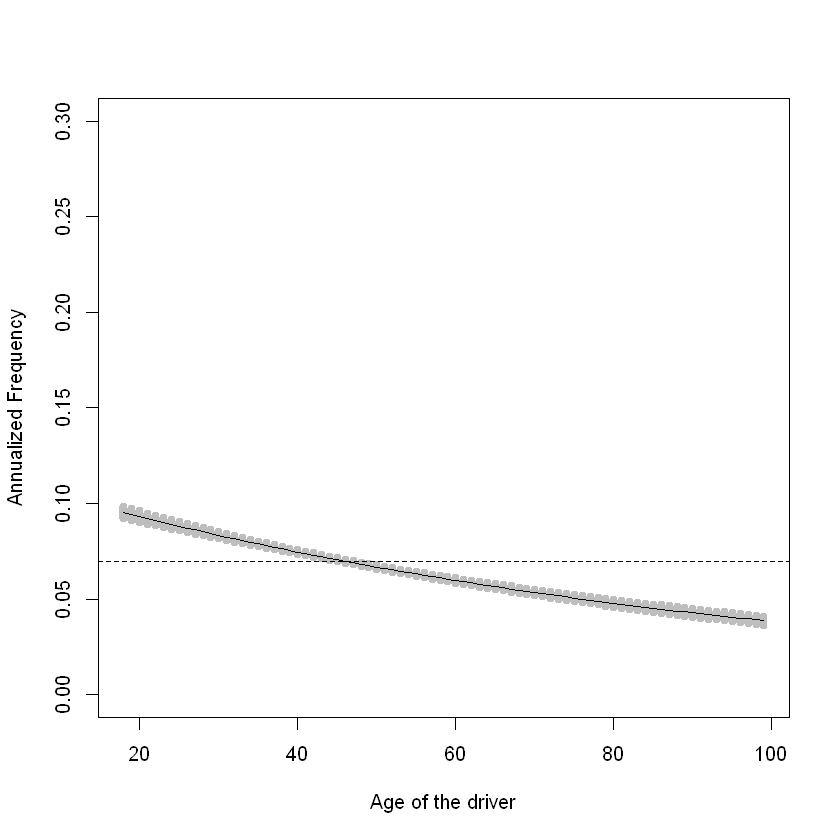

In [34]:
newdb <- data.frame(DriverAge=18:99, Exposure=1)
pred.poisson <- predict(reg.poisson, newdata=newdb, type="response", se=TRUE)
plot(18:99, pred.poisson$fit, type="l", xlab="Age of the driver", ylab="Annualized Frequency", ylim=c(0,.3), 
     col="white")
segments(18:99, pred.poisson$fit-2*pred.poisson$se.fit, 18:99, pred.poisson$fit+2*pred.poisson$se.fit, 
     col="grey", lwd=7)
lines(18:99, pred.poisson$fit)
abline(h=sum(freMTPLfreq$ClaimNb)/sum(freMTPLfreq$Exposure),lty=2)

This is a Poisson regression of the annualized frequency on the age of the driver, with a linear model, and when the age of the driver is a categorical variable. 

In order to get a nonparametric estimator, it is possible to consider the age (which is here an integer) as a factor variable:

In [35]:
reg.np <- glm(ClaimNb ~ as.factor(DriverAge) + offset(log(Exposure)), family=poisson, data=freMTPLfreq)

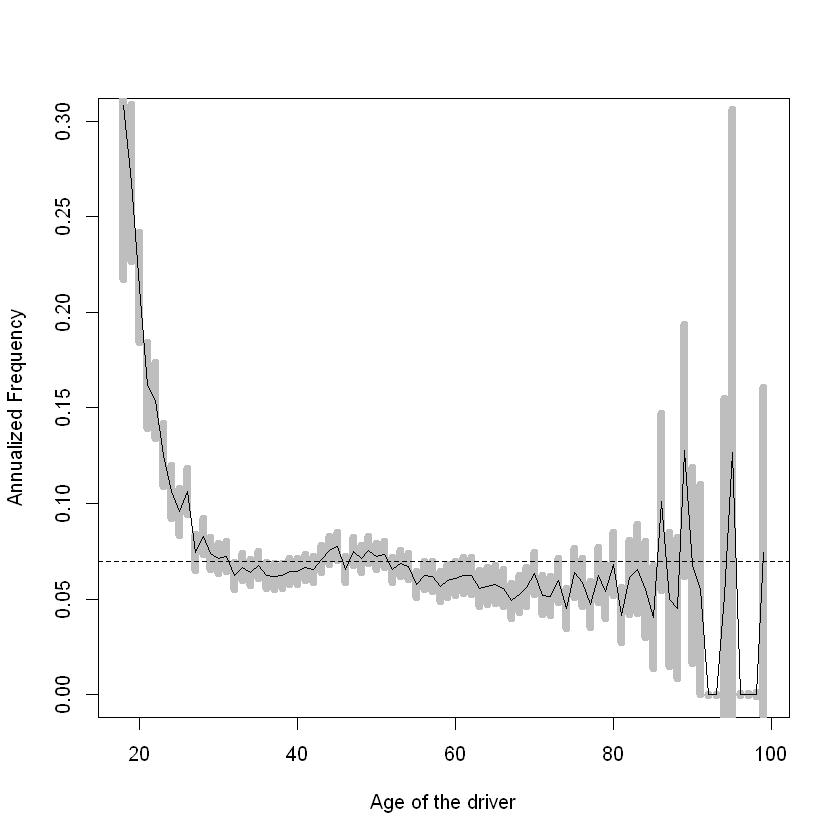

In [36]:
newdb2 <- data.frame(DriverAge=18:99, Exposure=1)
pred.np <- predict(reg.np, newdata=newdb2, type="response", se=TRUE)
plot(18:99, pred.np$fit, type="l", xlab="Age of the driver", ylab="Annualized Frequency", ylim=c(0,.3), 
     col="white")
segments(18:99, pred.np$fit-2*pred.np$se.fit, 18:99, pred.np$fit+2*pred.np$se.fit, 
     col="grey", lwd=7)
lines(18:99, pred.np$fit)
abline(h=sum(freMTPLfreq$ClaimNb)/sum(freMTPLfreq$Exposure),lty=2)

This is a Poisson regression of the annualized frequency on the age of the driver, per age as a factor (because it is a discrete variable).

To use spline regressions, we consider a linear model including s(X) instead of X, where s() will be estimated using penalized regression splines:

In [37]:
library(mgcv)
reg.splines <- gam(ClaimNb ~ s(DriverAge) + offset(log(Exposure)), family=poisson, data=freMTPLfreq)

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


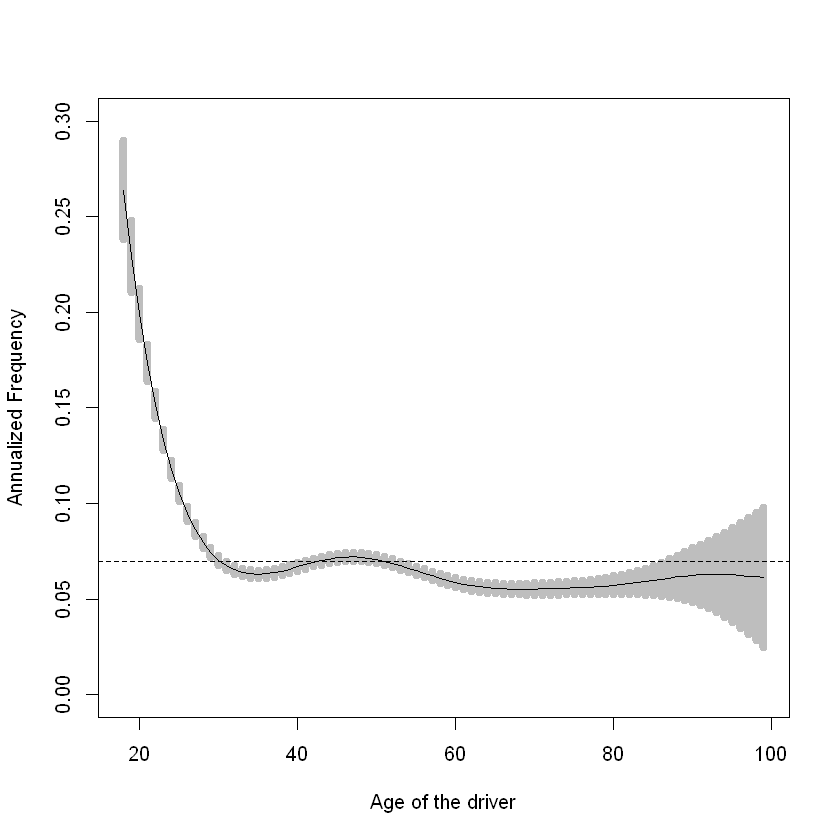

In [38]:
newdb3 <- data.frame(DriverAge=18:99, Exposure=1)
pred.splines <- predict(reg.splines, newdata=newdb3, type="response", se=TRUE)
plot(18:99, pred.splines$fit, type="l", xlab="Age of the driver", ylab="Annualized Frequency", ylim=c(0,.3), 
     col="white")
segments(18:99, pred.splines$fit-2*pred.splines$se.fit, 18:99, pred.splines$fit+2*pred.splines$se.fit, 
     col="grey", lwd=7)
lines(18:99, pred.splines$fit)
abline(h=sum(freMTPLfreq$ClaimNb)/sum(freMTPLfreq$Exposure),lty=2)

This is a Poisson regression of the annualized frequency on the age of the driver, per age as a factor (because it is a discrete variable) and using a spline smoother.

#### 1.7. A Poisson Regression to Model Yearly Claim Frequency

In order to have signicant factors, the age of the car is here only in two classes: less than 15 years old, and more than 15 years old:

In [39]:
freMTPLfreq.f$CarAge <- cut(freMTPLfreq$CarAge,c(0,15,Inf), include.lowest = TRUE)

The levels are here

In [40]:
levels(freMTPLfreq.f$CarAge)

[1] "[0,15]"   "(15,Inf]"

For the brand, we only distinguish cars of brand F,

In [41]:
freMTPLfreq.f$brandF <- factor(freMTPLfreq.f$Brand=="Fiat",labels=c("other","F"))

and for the power of the car, three classes are considered here,

In [42]:
freMTPLfreq.f$powerF <- factor(1*(freMTPLfreq.f$Power%in%letters[4:6]) + 2*(freMTPLfreq.f$Power%in%letters[7:8]),
                             labels=c("other","DEF","GH"))

Our model here is

In [43]:
freg <- formula(ClaimNb ~ DriverAge + CarAge + Density + brandF + powerF + Gas + offset(log(Exposure)))
regp <- glm(freg,data=freMTPLfreq.f,family=poisson(link="log"))
summary(regp)


Call:
glm(formula = freg, family = poisson(link = "log"), data = freMTPLfreq.f)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7836  -0.3391  -0.2654  -0.1487   6.5261  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.69761    0.04644 -36.553  < 2e-16 ***
DriverAge(22,26]     -0.62633    0.04609 -13.590  < 2e-16 ***
DriverAge(26,42]     -1.09491    0.03648 -30.013  < 2e-16 ***
DriverAge(42,74]     -1.09381    0.03561 -30.718  < 2e-16 ***
DriverAge(74,Inf]    -1.10825    0.05189 -21.357  < 2e-16 ***
CarAge(15,Inf]       -0.22564    0.03073  -7.342 2.10e-13 ***
Density(40,200]       0.17957    0.02676   6.710 1.95e-11 ***
Density(200,500]      0.30994    0.02968  10.443  < 2e-16 ***
Density(500,4.5e+03]  0.51416    0.02598  19.792  < 2e-16 ***
Density(4.5e+03,Inf]  0.60605    0.03497  17.331  < 2e-16 ***
brandFF               0.06639    0.03839   1.730   0.0837 .  
powerFDEF            -0.15566    0.02409  -6.4

#### 1.8. More Advanced Models for Counts:  Negative Binomial Regression

The negative binomial regression is obtained using glm.nb of library MASS, while zeroinfl and hurdle functions are obtained using library pscl.

In [44]:
library(MASS)
library(pscl)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


In [45]:
regnb <- glm(ClaimNb ~ Gas + DriverAge + Density + offset(log(Exposure)),
             family=negative.binomial(1), data=freMTPLfreq.f)
summary(regnb)


Call:
glm(formula = ClaimNb ~ Gas + DriverAge + Density + offset(log(Exposure)), 
    family = negative.binomial(1), data = freMTPLfreq.f)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7239  -0.3343  -0.2653  -0.1491   5.8679  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.84232    0.05452 -33.789  < 2e-16 ***
GasRegular           -0.20618    0.02130  -9.679  < 2e-16 ***
DriverAge(22,26]     -0.62912    0.06215 -10.123  < 2e-16 ***
DriverAge(26,42]     -1.09797    0.04932 -22.264  < 2e-16 ***
DriverAge(42,74]     -1.09583    0.04814 -22.764  < 2e-16 ***
DriverAge(74,Inf]    -1.12802    0.06959 -16.211  < 2e-16 ***
Density(40,200]       0.18531    0.03536   5.241  1.6e-07 ***
Density(200,500]      0.31932    0.03926   8.133  4.2e-16 ***
Density(500,4.5e+03]  0.52864    0.03433  15.399  < 2e-16 ***
Density(4.5e+03,Inf]  0.63692    0.04620  13.785  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0

In [46]:
regnb2 <- glm.nb(freg,data=freMTPLfreq.f) #NB2 Variance Form: Negative Binomial Type II
summary(regnb2)


Call:
glm.nb(formula = freg, data = freMTPLfreq.f, init.theta = 0.8518201379, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7338  -0.3348  -0.2634  -0.1489   5.8073  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.67355    0.04849 -34.511  < 2e-16 ***
DriverAge(22,26]     -0.64183    0.04835 -13.275  < 2e-16 ***
DriverAge(26,42]     -1.11611    0.03846 -29.020  < 2e-16 ***
DriverAge(42,74]     -1.11473    0.03759 -29.658  < 2e-16 ***
DriverAge(74,Inf]    -1.13280    0.05409 -20.945  < 2e-16 ***
CarAge(15,Inf]       -0.22349    0.03146  -7.103 1.22e-12 ***
Density(40,200]       0.18018    0.02742   6.571 5.01e-11 ***
Density(200,500]      0.31114    0.03047  10.211  < 2e-16 ***
Density(500,4.5e+03]  0.51604    0.02667  19.350  < 2e-16 ***
Density(4.5e+03,Inf]  0.60611    0.03600  16.838  < 2e-16 ***
brandFF               0.07084    0.03961   1.789   0.0737 .  
powerFDEF            -0.15342  

#### 1.9. More Advanced Models for Counts:   Zero-Inflated Models

If we consider a zero-in ated Poisson model, with constant probability $\pi$, we obtain

In [47]:
fregzi <- formula(ClaimNb ~ DriverAge + CarAge + Density + brandF + powerF + Gas + 
                  offset(log(Exposure)))
regzip = zeroinfl(fregzi, data=freMTPLfreq.f, dist = "poisson", link="logit")
summary(regzip)


Call:
zeroinfl(formula = fregzi, data = freMTPLfreq.f, dist = "poisson", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.4355 -0.2218 -0.1918 -0.1373 66.3063 

Count model coefficients (poisson with log link):
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.29616    0.11074 -11.704  < 2e-16 ***
DriverAge(22,26]     -0.40480    0.10250  -3.949 7.83e-05 ***
DriverAge(26,42]     -1.03283    0.07896 -13.080  < 2e-16 ***
DriverAge(42,74]     -1.00369    0.07652 -13.117  < 2e-16 ***
DriverAge(74,Inf]    -0.88069    0.13298  -6.623 3.52e-11 ***
CarAge(15,Inf]        0.24015    0.08095   2.967 0.003012 ** 
Density(40,200]       0.18032    0.07327   2.461 0.013848 *  
Density(200,500]      0.21369    0.07952   2.687 0.007205 ** 
Density(500,4.5e+03]  0.32340    0.06994   4.624 3.77e-06 ***
Density(4.5e+03,Inf]  0.30969    0.09095   3.405 0.000662 ***
brandFF               0.19946    0.09420   2.118 0.034217 *  
powerFDEF    

If we consider a probability $\pi_i$ function of the age of the driver, we obtain

In [48]:
fregzi <- formula(ClaimNb ~ DriverAge + CarAge + Density + brandF + powerF + Gas 
                  + offset(log(Exposure))|DriverAge)
regzip = zeroinfl(fregzi, data=freMTPLfreq.f, dist = "poisson", link="logit")
summary(regzip)


Call:
zeroinfl(formula = fregzi, data = freMTPLfreq.f, dist = "poisson", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.4888 -0.2334 -0.1847 -0.1049 95.9208 

Count model coefficients (poisson with log link):
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.97380    0.11560  -8.424  < 2e-16 ***
DriverAge(22,26]     -0.39996    0.15827  -2.527   0.0115 *  
DriverAge(26,42]     -1.11721    0.12815  -8.718  < 2e-16 ***
DriverAge(42,74]     -1.12698    0.12225  -9.218  < 2e-16 ***
DriverAge(74,Inf]    -0.77096    0.18359  -4.199 2.68e-05 ***
CarAge(15,Inf]       -0.22224    0.03155  -7.044 1.86e-12 ***
Density(40,200]       0.18069    0.02745   6.581 4.66e-11 ***
Density(200,500]      0.31143    0.03051  10.208  < 2e-16 ***
Density(500,4.5e+03]  0.51623    0.02670  19.334  < 2e-16 ***
Density(4.5e+03,Inf]  0.60764    0.03601  16.874  < 2e-16 ***
brandFF               0.07283    0.03976   1.832   0.0670 .  
powerFDEF    

#### 1.10. More Advanced Models for Counts:   Hurdle Models

The Hurdle distribution is based on a dichotomic process, where insureds that report are considered completely different from those who report at least once.

In [49]:
freghrd <- formula(ClaimNb ~ DriverAge + CarAge + Density + brandF + powerF + Gas 
                  + offset(log(Exposure))|DriverAge)
reghrd = hurdle(freghrd, data=freMTPLfreq.f, dist="negbin", zero.dist="binomial", link="logit")
summary(reghrd)


Call:
hurdle(formula = freghrd, data = freMTPLfreq.f, dist = "negbin", zero.dist = "binomial", 
    link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.2787 -0.1960 -0.1923 -0.1826 21.9764 

Count model coefficients (truncated negbin with log link):
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.972525   1.131412  -2.627  0.00861 ** 
DriverAge(22,26]     -0.343822   0.182719  -1.882  0.05988 .  
DriverAge(26,42]     -1.040089   0.149683  -6.949 3.69e-12 ***
DriverAge(42,74]     -1.046796   0.143645  -7.287 3.16e-13 ***
DriverAge(74,Inf]    -0.653846   0.207626  -3.149  0.00164 ** 
CarAge(15,Inf]       -0.131226   0.162096  -0.810  0.41819    
Density(40,200]       0.464442   0.154026   3.015  0.00257 ** 
Density(200,500]      0.423039   0.167821   2.521  0.01171 *  
Density(500,4.5e+03]  0.757230   0.148217   5.109 3.24e-07 ***
Density(4.5e+03,Inf]  1.392947   0.172152   8.091 5.90e-16 ***
brandFF               0.0037

### 2. Individual Claims

#### 2.1. Dataset

The second dataset, CLAIMS, contains claims information, from the same company

    Att. 1 (numeric) ID, contract number (used to link with the contract dataset)
    Att. 2 (numeric) INDEMNITY, cost of the claim, seen as at a recent date.

In [50]:
data(freMTPLfreq)
freMTPLfreq.f <- freMTPLfreq

In [51]:
data(freMTPLsev)
tail(freMTPLsev)

,PolicyID,ClaimAmount
16176,303133,769
16177,302759,61
16178,299443,1831
16179,303389,4183
16180,304313,566
16181,206241,2156


It is possible to merge this dataset with the one that contains information about the freMTPLfreq:

In [52]:
claims <- merge(freMTPLsev,freMTPLfreq)
head(claims)

PolicyID,ClaimAmount,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
33,302,1,0.75,g,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
41,2001,1,0.14,l,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56
92,1449,1,0.14,d,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792
96,9924,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
96,946,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
142,1390,1,0.75,e,0,34,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,1565


In [53]:
claims.f <- merge(freMTPLsev,freMTPLfreq.f)
head(claims.f)

PolicyID,ClaimAmount,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
33,302,1,0.75,g,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
41,2001,1,0.14,l,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56
92,1449,1,0.14,d,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792
96,9924,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
96,946,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000
142,1390,1,0.75,e,0,34,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,1565


Note that this dataset contains only claims with a strictly positive indemnity (losses claims but filed away are not in this dataset). Thus, what we need to model losses is a distribution on R+.

The tools used for individual claims are the same as claims frequency, Generalized Linear Models. However, in practice, covariates are much less informative to predict amounts than to predict frequency.

#### 2.2 Log-Normal Model vs. Gamma  Model

In [54]:
reg.logn <- lm(log(ClaimAmount) ~ DriverAge + Gas, data=claims[claims$ClaimAmount<15000,])
summary(reg.logn)


Call:
lm(formula = log(ClaimAmount) ~ DriverAge + Gas, data = claims[claims$ClaimAmount < 
    15000, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1337 -0.2550  0.2586  0.3484  2.8972 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.699883   0.027018 247.976  < 2e-16 ***
DriverAge    0.002227   0.000554   4.020 5.86e-05 ***
GasRegular  -0.028249   0.016542  -1.708   0.0877 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.044 on 16003 degrees of freedom
Multiple R-squared:  0.001153,	Adjusted R-squared:  0.001028 
F-statistic: 9.236 on 2 and 16003 DF,  p-value: 9.802e-05


In [55]:
reg.gamma <- glm(ClaimAmount ~ DriverAge + Gas, family=Gamma(link="log"), data=claims[claims$ClaimAmount<15000,])
summary(reg.gamma)


Call:
glm(formula = ClaimAmount ~ DriverAge + Gas, family = Gamma(link = "log"), 
    data = claims[claims$ClaimAmount < 15000, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3222  -0.6123  -0.1513  -0.0803   3.9790  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.2450846  0.0281934 256.978   <2e-16 ***
DriverAge   -0.0006117  0.0005781  -1.058    0.290    
GasRegular  -0.0233642  0.0172617  -1.354    0.176    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 1.187346)

    Null deviance: 13455  on 16005  degrees of freedom
Residual deviance: 13451  on 16003  degrees of freedom
AIC: 262087

Number of Fisher Scoring iterations: 5


#### 2.3. Large Claims and Ratemaking

If claims are not too large, then the log-normal and the gamma regressions should be quite close, as mentioned in the section above. But consider the following two regressions, on the age of the driver (as a continuous variate):

In [56]:
reg.logn <- lm(log(ClaimAmount) ~ DriverAge,data=claims)
summary(reg.logn)


Call:
lm(formula = log(ClaimAmount) ~ DriverAge, data = claims)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1612 -0.2802  0.2204  0.3081  7.7520 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.7361807  0.0277458 242.782  < 2e-16 ***
DriverAge   0.0020374  0.0005868   3.472 0.000518 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.115 on 16179 degrees of freedom
Multiple R-squared:  0.0007446,	Adjusted R-squared:  0.0006828 
F-statistic: 12.06 on 1 and 16179 DF,  p-value: 0.0005177


In [57]:
reg.gamma <- glm(ClaimAmount ~ DriverAge,family=Gamma(link="log"),data=claims)
summary(reg.gamma)


Call:
glm(formula = ClaimAmount ~ DriverAge, family = Gamma(link = "log"), 
    data = claims)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.520  -0.926  -0.565  -0.365  38.540  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.095074   0.203485  39.782   <2e-16 ***
DriverAge   -0.009926   0.004304  -2.307   0.0211 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 66.85011)

    Null deviance: 27064  on 16180  degrees of freedom
Residual deviance: 26607  on 16179  degrees of freedom
AIC: 279095

Number of Fisher Scoring iterations: 9


Here, coefficients are significant, but with opposite signs. With a Gamma regression, the younger the driver, the less expensive the claims, while it is the reverse with a log-normal regression. The interpretation is related to large claims: outliers will affect the Gamma regression more than the log-normal one (because it is a regression on the logarithm of losses). On the other hand, on average, predictions obtained with a log-normal model may not be consistent with observed losses: here, the average cost of the claim was

In [58]:
mean(claims$ClaimAmount)

[1] 2129.972

and the average predictions were, with the two models,

In [59]:
mean(predict(reg.gamma,type="response"))

[1] 2122.852

In [60]:
sigma <- summary(reg.logn)$sigma
mean(exp(predict(reg.logn))*exp(sigma^2/2))

[1] 1718.994

So, in order to have a more robust pricing method, we should find a way to deal with large claims. A natural technique is to consider that differentiating premiums should be valid for standard claims, while extremely large ones might be spread between all the insureds, without differentiating (pooling extremely large losses among the insureds).

In [61]:
M <- claims[order(-claims$ClaimAmount),c("ClaimAmount","ClaimNb","Power", "CarAge","DriverAge","Gas","Density")]
M$SUM <- cumsum(M$ClaimAmount)/sum(M$ClaimAmount)*100
head(M)

,ClaimAmount,ClaimNb,Power,CarAge,DriverAge,Gas,Density,SUM
5033,2036833,1,i,13,19,Regular,93,5.909846
1854,1402330,2,f,13,20,Regular,203,9.978689
4948,306559,1,g,1,21,Diesel,108,10.868167
2637,301302,1,f,3,46,Diesel,10,11.742391
11566,281403,1,f,4,61,Diesel,1064,12.558878
4512,254944,1,d,12,27,Regular,319,13.298595


The largest claim cost more than 2 million euros, almost 6% of the total loss. The three largest (almost 11% of the total loss) were caused by young drivers (19, 20, and 21 years
old, respectively).

#### 2.4. Model with Two Kinds of Claims

A standard result in probability theory gives any conditional expectation composed of

     A is the average cost of normal claims (excluding claims that exceed s)
     B is the average cost of large claims (those that exceed s)
     C is the probability of having a large or a normal claim

For part C, a logistic regression can be run. For parts A and B, regressions are on subsets of the dataset. Consider a threshold s <- 10000, reached by less than 2% of the claims:

In [62]:
claims$Standard <- (claims$ClaimAmount < 10000)
mean(claims$Standard)

[1] 0.982943

Consider a logistic regression to model the probability that a claim will be a standard one:

In [63]:
library(splines)
age <- seq(18,100)
regC <- glm(Standard ~ bs(DriverAge), data=claims, family=binomial)
ypC <- predict(regC, newdata=data.frame(DriverAge=age), type="response", se=TRUE)

Warning message in bs(DriverAge, degree = 3L, knots = numeric(0), Boundary.knots = c(18L, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"

The probability can be visualized by

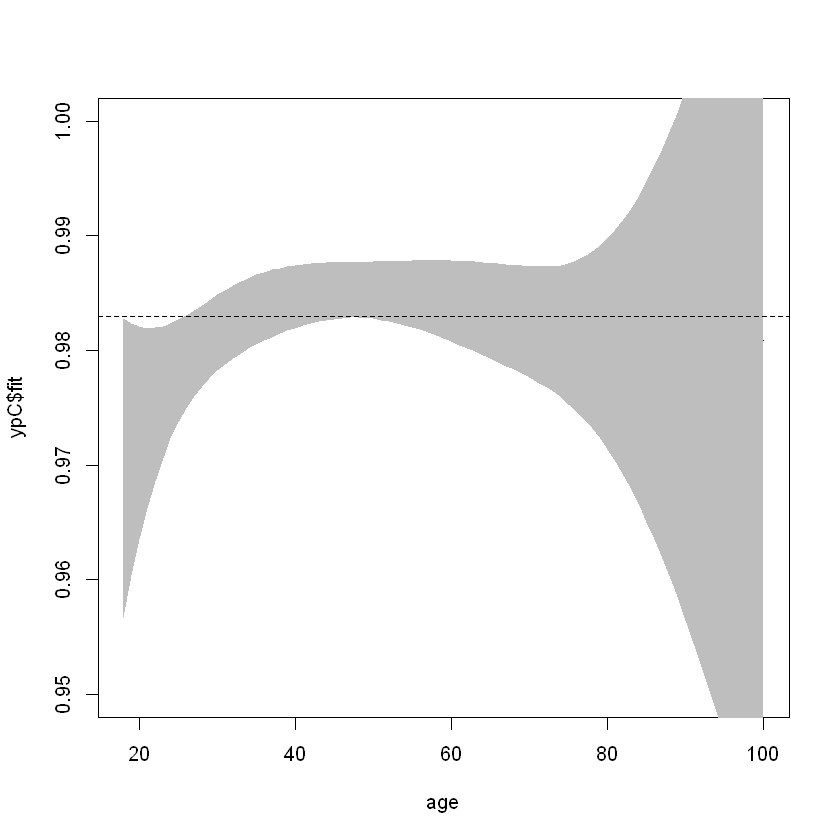

In [64]:
plot(age,ypC$fit,ylim=c(.95,1),type="l",)
    polygon(c(age,rev(age)),c(ypC$fit+2*ypC$se.fit,rev(ypC$fit-2*ypC$se.fit)), col="grey",border=NA)
abline(h=mean(claims$Standard),lty=2)

The figure above is probability of having a standard claim (smaller than the threshold), given that a claim occurred, as a function of the age of the driver. Logistic regression with a spline smoother.

For standard and large claims, consider two gamma regressions on the two subsets,

In [65]:
indexstandard <- which(claims$ClaimAmount < 10000)
mean(claims$ClaimAmount[indexstandard])

[1] 1280.085

In [66]:
mean(claims$ClaimAmount[-indexstandard])

[1] 51106.23

In [67]:
regA <- glm(ClaimAmount ~ bs(DriverAge), data=claims[indexstandard,], family=Gamma(link="log"))
ypA <- predict(regA, newdata=data.frame(DriverAge=age), type="response")

Warning message in bs(DriverAge, degree = 3L, knots = numeric(0), Boundary.knots = c(18L, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"

In [68]:
regB <- glm(ClaimAmount~bs(DriverAge), data=claims[-indexstandard,], family=Gamma(link="log"))
ypB <- predict(regB, newdata=data.frame(DriverAge=age), type="response")

Warning message in bs(DriverAge, degree = 3L, knots = numeric(0), Boundary.knots = c(18L, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"

In order to compare, let us fit one model on the overall dataset:

In [69]:
reg <- glm(ClaimAmount~bs(DriverAge), data=claims, family=Gamma(link="log"))
yp <- predict(reg, newdata=data.frame(DriverAge=age), type="response")

Warning message in bs(DriverAge, degree = 3L, knots = numeric(0), Boundary.knots = c(18L, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"

and let us compare the two approaches on by

Warning message in bs(DriverAge, degree = 3L, knots = numeric(0), Boundary.knots = c(18L, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"

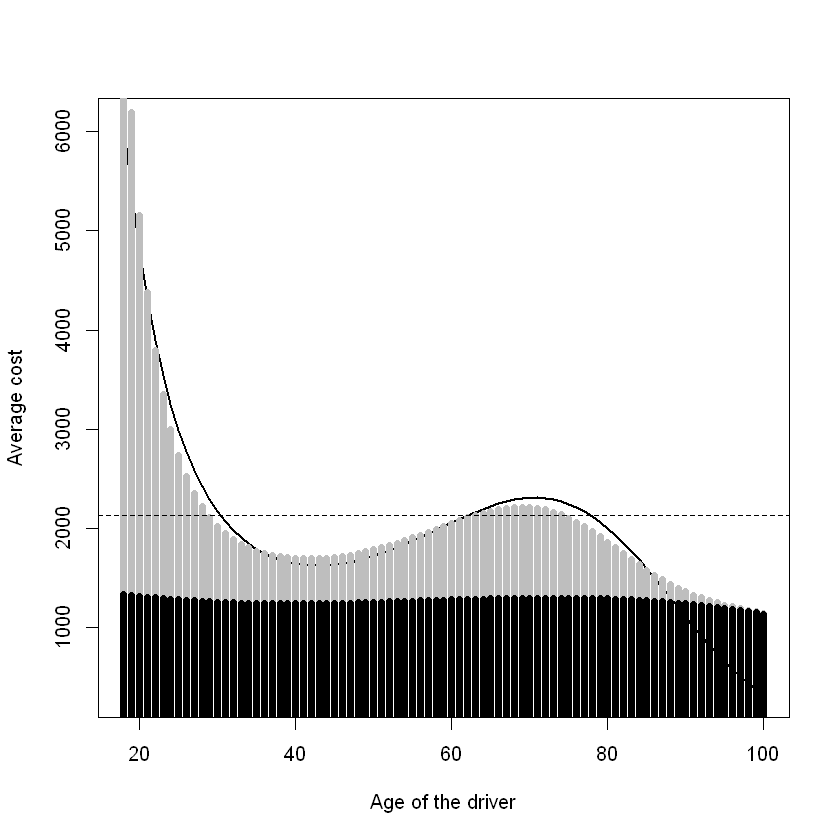

In [70]:
ypC <- predict(regC, newdata=data.frame(DriverAge=age), type="response")
plot(age, yp, type="l", lwd=2, ylab="Average cost", xlab="Age of the driver")
lines(age, ypC*ypA+(1-ypC)*ypB, type="h", col="grey", lwd=6)
lines(age, ypC*ypA, type="h", col="black", lwd=6)
abline(h= mean(claims$ClaimAmount), lty=2)

The dotted horizontal line is the average cost of a claim. The dark line, in the back, is the prediction on the whole dataset reg. The dark part is the part of the average claim related to standard claims (smaller than s) and the lighter area is the part of the average claim due to possible large claims (exceeding s).

#### 2.5. More General Model

In [71]:
library(nnet)
threshold <- c(0,1150,10000,Inf)
regD <- multinom(cut(claims$ClaimAmount, breaks=threshold) ~ bs(DriverAge), data=claims)
summary(regD)


Attaching package: 'nnet'

The following object is masked from 'package:mgcv':

    multinom



# weights:  15 (8 variable)
initial  value 17776.645443 
iter  10 value 12391.379124
final  value 12389.058985 
converged


Call:
multinom(formula = cut(claims$ClaimAmount, breaks = threshold) ~ 
    bs(DriverAge), data = claims)

Coefficients:
                 (Intercept) bs(DriverAge)1 bs(DriverAge)2 bs(DriverAge)3
(1.15e+03,1e+04]    0.126849     -0.5866635      0.4435400      0.2998493
(1e+04,Inf]        -2.716344     -1.8494277      0.1237384     -0.2909207

Std. Errors:
                 (Intercept) bs(DriverAge)1 bs(DriverAge)2 bs(DriverAge)3
(1.15e+03,1e+04]  0.06893703      0.2353106      0.2562023      0.3562258
(1e+04,Inf]       0.22592318      0.8219250      0.9575998      1.2674017

Residual Deviance: 24778.12 
AIC: 24794.12 

For instance, for drivers with age 20 or 50, given that a claim has occurred, the probability that it could be in one of the three tranches will be

In [72]:
predict(regD, newdata=data.frame(DriverAge=c(20,50)), type="probs")

"(0,1.15e+03]","(1.15e+03,1e+04]","(1e+04,Inf]"
0.4655077,0.5074693,0.02702298
0.4885641,0.4967026,0.01473323


If we plot the parts due to small claims (less than s1), medium claims (from s1 to s2), and
large claims (more than s2), we obtain the graph as

### 3. Modeling Compound Sum with Tweedie Regression

A natural idea is to use a Tweedie model on the aggregated sum, per insured.

In [73]:
library(tweedie)

In [74]:
A <- tapply(claims$ClaimAmount, claims$PolicyID, sum)
ADF <- data.frame(PolicyID=names(A), ClaimAmount=as.vector(A))
CT <- merge(freMTPLfreq, ADF, all.x=TRUE)
CT$ClaimAmount[is.na(CT$ClaimAmount)] <- 0
tail(CT)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
413164,413164,0,0.005479452,d,0,61,Japanese (except Nissan) or Korean,Regular,Basse-Normandie,205,0
413165,413165,0,0.002739726,j,0,29,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,2471,0
413166,413166,0,0.005479452,d,0,29,Japanese (except Nissan) or Korean,Regular,Ile-de-France,5360,0
413167,413167,0,0.005479452,k,0,49,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,5360,0
413168,413168,0,0.002739726,d,0,41,Japanese (except Nissan) or Korean,Regular,Ile-de-France,9850,0
413169,413169,0,0.002739726,g,6,29,Japanese (except Nissan) or Korean,Diesel,Aquitaine,65,0


In [75]:
CT.f = merge(freMTPLfreq.f, ADF, all.x=TRUE)
CT.f$ClaimAmount[is.na(CT.f$ClaimAmount)] <- 0
tail(CT.f)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
413164,413164,0,0.005479452,d,0,61,Japanese (except Nissan) or Korean,Regular,Basse-Normandie,205,0
413165,413165,0,0.002739726,j,0,29,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,2471,0
413166,413166,0,0.005479452,d,0,29,Japanese (except Nissan) or Korean,Regular,Ile-de-France,5360,0
413167,413167,0,0.005479452,k,0,49,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,5360,0
413168,413168,0,0.002739726,d,0,41,Japanese (except Nissan) or Korean,Regular,Ile-de-France,9850,0
413169,413169,0,0.002739726,g,6,29,Japanese (except Nissan) or Korean,Diesel,Aquitaine,65,0


Using library tweedie we obtain

In [76]:
out <- tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + Gas + Density,
                       data=CT.f, p.vec=seq(1.05,1.95,by=.05))

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 1.95 
..............

Warning message:
"glm.fit: algorithm did not converge"

.

Warning message in tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + :
"  Problem near  p  =  1.75 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

.

Warning message:
"step size truncated due to divergence"Warning message in tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + :
"  Problem near  p  =  1.8 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

.

Warning message:
"step size truncated due to divergence"Warning message in tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + :
"  Problem near  p  =  1.85 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

.

Warning message:
"step size truncated due to divergence"Warning message in tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + :
"  Problem near  p  =  1.9 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

.

Warning message:
"step size truncated due to divergence"Warning message in tweedie.profile(ClaimAmount ~ Power + CarAge + DriverAge + Brand + :
"  Problem near  p  =  1.95 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

Done.


We can then plot the prole likelihood function associated to the Tweedie regression:

In [77]:
out$p.max

[1] 1.576531

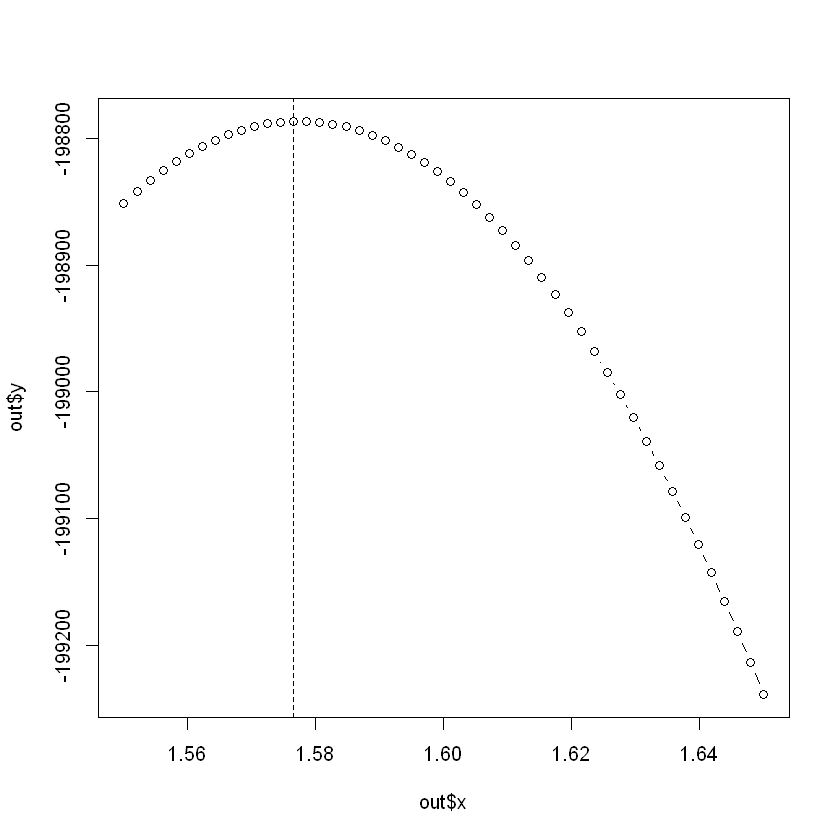

In [78]:
plot(out,type="b")
abline(v=out$p.max,lty=2)

In order to ensure convergence of the algorithm, we can use coefficients obtained from a Poisson regression:

In [79]:
library(statmod)
reg1 <- glm(ClaimAmount ~ Power + CarAge + DriverAge + Brand + Gas + Density, 
            data=CT.f, family = tweedie(var.power = 1, link.power = 0))
summary(reg1)


Call:
glm(formula = ClaimAmount ~ Power + CarAge + DriverAge + Brand + 
    Gas + Density, family = tweedie(var.power = 1, link.power = 0), 
    data = CT.f)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -26.5   -14.1   -12.3   -10.6  5610.2  

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              4.620e+00  3.680e-01  12.553  < 2e-16
Powere                                   6.425e-02  1.969e-01   0.326    0.744
Powerf                                   3.977e-01  1.821e-01   2.184    0.029
Powerg                                   1.614e-01  1.853e-01   0.871    0.384
Powerh                                   1.215e-01  2.765e-01   0.439    0.661
Poweri                                   1.013e+00  2.230e-01   4.543 5.54e-06
Powerj                                   3.082e-01  2.999e-01   1.028    0.304
Powerk                                   2.617e-01  3.875e-01   0.675    0.499
Powerl     

The following function returns as a function of p:

In [80]:
coef <- function(p){
    glm(ClaimAmount ~ Power + CarAge + DriverAge + Brand + Gas + Density,
    data=CT.f, family = tweedie(var.power = p, link.power = 0), start=reg1$coefficients)$coefficients}

It is also possible to visualize the evolution of the coecients estimates as a function of p (without the (Intercept)), with a logarithm link function:

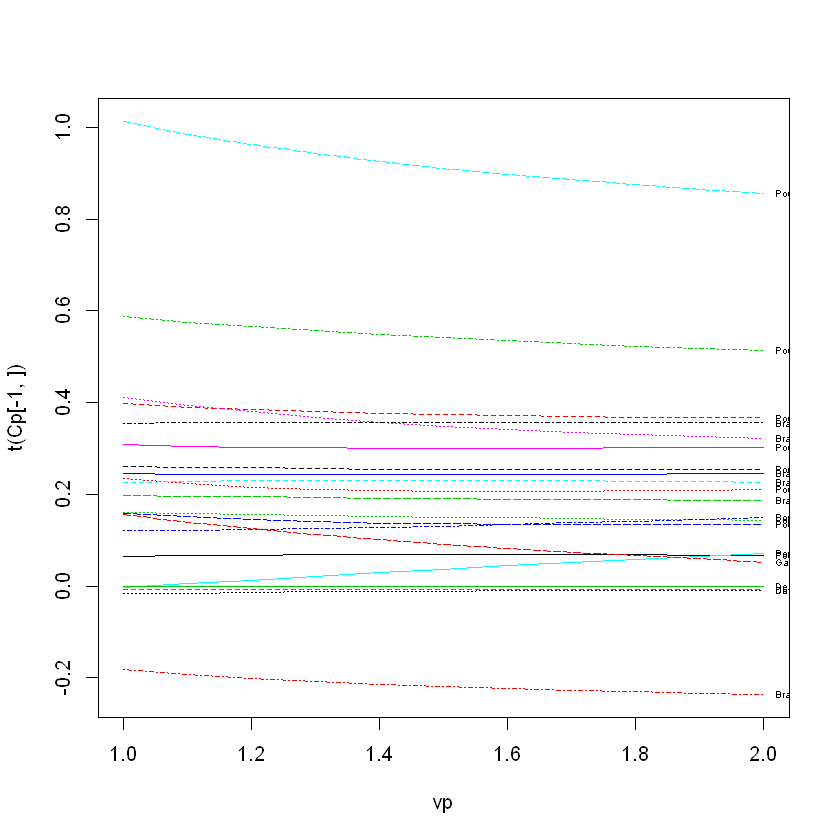

In [81]:
vp <- seq(1,2,by=.1)
Cp <- Vectorize(coef)(vp)
matplot(vp,t(Cp[-1,]),type="l")
text(2,Cp[-1,length(vp)],rownames(Cp[-1,]),cex=.5,pos=4)

One can also use library cplm for tting Tweedie compound Poisson linear models.